# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image models on MNIST using Estimator.
<hr/>
This <a href="mnist_models.ipynb">companion notebook</a> extends the basic harness of this notebook to a variety of models including DNN, CNN, dropout, pooling etc.

In [1]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


## Exploring the data

Let's download MNIST data and examine the shape. We will need these numbers ...

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [9]:
mnist # check what's in it, can see trian, validation and test

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fd71eabc6a0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fd71e3a6f60>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fd71e3a6da0>)

In [11]:
print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

(5000, 28, 28, 1)
(5000, 10)


In [3]:
# Configured as global variables...oook.
HEIGHT=28
WIDTH=28
NCLASSES=10

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


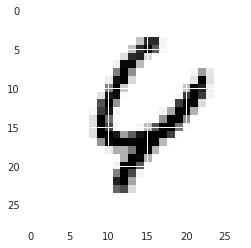

In [7]:
import matplotlib.pyplot as plt
IMGNO=121
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model.
Let's start with a very simple linear classifier. All our models will have this basic interface -- they will take an image and return logits.

In [17]:
def linear_model(img):
    """
    #TODO
    This one needs to go from raw input image data, into a vector of the relative confidence 
    probailities of each classes, as well as the number of classes in the model
    
    Note this is a linear model, so even thought it output says ylogit, the values will be 
    any real number, because not converted into a logit
    """
    X = tf.reshape(img, [-1, HEIGHT*WIDTH])  # flatten into 1D vector of [-1, H*W]
    W = tf.Variable(tf.zeros([HEIGHT*WIDTH, NCLASSES])) # this is [HEIGHT*WIDTH, CLASSES]
    b = tf.Variable(tf.zeros([NCLASSES])) # this is a scalar [NCLASSES]
    ylogits = tf.matmul(X, W) + b # [-1, NCLASSES]  after the matrix multiply    
    
    return ylogits, NCLASSES

## Write Input Functions

As usual, we need to specify input functions for training, evaluation, and predicition.

In [18]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.train.images},
    y=mnist.train.labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True,
    queue_capacity=5000
  )

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    #TODO
    x={'image':mnist.validation.images},
    y=mnist.validation.labels,
    batch_size=100,
    num_epochs=1,
    shuffle=False,
    queue_capacity=5000
  )

def serving_input_fn():
    inputs = {'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
    features = inputs # as-is
    return tf.estimator.export.ServingInputReceiver(features, inputs)

## Write Custom Estimator
I could have simply used a canned LinearClassifier, but later on, I will want to use different models, and so let's write a custom estimator

In [19]:
def image_classifier(features, labels, mode, params):
  ylogits, nclasses = linear_model(features['image'])
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities, 1), tf.uint8)
  
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ylogits, labels=labels))
    evalmetrics =  {'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels, 1))}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                                 learning_rate=params['learning_rate'], optimizer="Adam")
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
 
  return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"probabilities": probabilities, "classes": classes},
        loss=loss,
        train_op=train_op,
        eval_metric_ops=evalmetrics,
        export_outputs={'classes': tf.estimator.export.PredictOutput({"probabilities": probabilities, "classes": classes})}
    )

 tf.estimator.train_and_evaluate does distributed training.

In [20]:
def train_and_evaluate(output_dir, hparams):
  estimator = tf.estimator.Estimator(model_fn = image_classifier,
                                     params = hparams,
                                     model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn,
                                    max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('Servo', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn,
                                  steps = None,
                                  exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

This is the main() function

In [21]:
OUTDIR='mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {'train_steps': 1000, 'learning_rate': 0.01}
train_and_evaluate(OUTDIR, hparams)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd71b749a90>, '_task_type': 'worker', '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_master': '', '_service': None, '_num_ps_replicas': 0, '_model_dir': 'mnist/learned', '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_train_distribute': None, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_is_chief': True, '_task_id': 0}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorfl

What accuracy did you achieve?

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>